In [1]:
import math
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 -  4*x + 5

In [3]:
f(3.0)

20.0

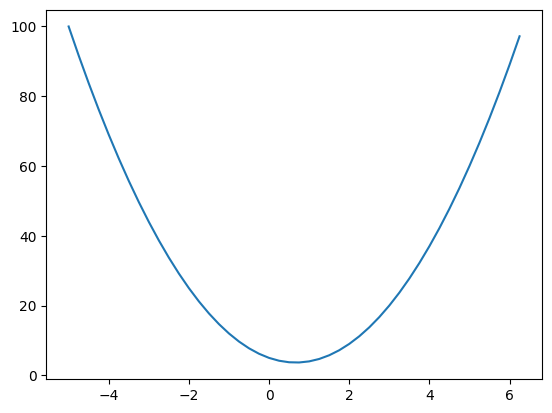

In [4]:
xs=np.arange(-5, 6.26, 0.25)
ys=f(xs)    
plt.plot(xs, ys)

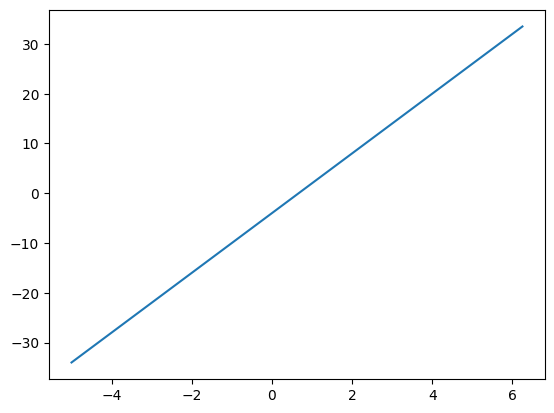

In [5]:
def derf(x):     # derivative of f(x)
    return 6*x - 4

xs=np.arange(-5, 6.26, 0.25)
ys=derf(xs)
plt.plot(xs, ys)

In [6]:
h = 0.0000001
x = -3.0
derivative = (f(x+h) - f(x))/h
print(derivative)

-21.999999688659955


In [7]:
# lets get more complex

a=2.0
b=-3.0
c=10.0  
d=a*b + c
print(d)

4.0


In [8]:
h = 0.0001

# Inputs
a=2.0
b=-3.0
c=10.0  


d1=a*b + c
a+=h
d2=a*b + c

print('d1 -->', d1) 
print('d2 -->', d2)
print('slope -->', (d2-d1)/h)

d1 --> 4.0
d2 --> 3.999699999999999
slope --> -3.000000000010772


d2 decreased => slope is negative

In [72]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad=0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1*out.grad
            other.grad += 1*out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data*out.grad
            other.grad += self.data*out.grad
        out._backward = _backward
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other*self.data**(other-1))*out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other): # other*Value(2.0)
        return self * other
    
    def __truediv__(self, other):
        return self * other**-1
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        def _backward():
            self.grad += (1-t**2)*out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        def _backward():
            self.grad += math.exp(x)*out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set() 
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1
        for node in reversed(topo):
            node._backward()
    
    
a=Value(2.0, label='a')
b=Value(-3.0, label='b')
c=Value(10.0, label='c')
e=a+b; e.label='e'
d=e+c; d.label='d'
f=Value(3.0, label='f')
L=d*f; L.label='L'
L

Value(data=27.0)

In [10]:
from graphviz import Digraph # type: ignore

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

In [11]:
def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})   # Left to Right
    nodes, edges = trace(root)
    for n in nodes:
        uid= str(id(n))
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot

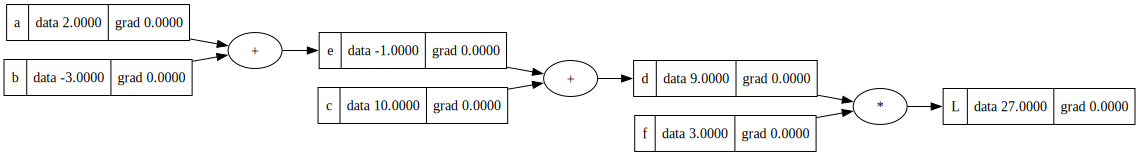

In [12]:
draw_dot(L)

In [13]:
d.grad= 6.0
f.grad=12.0

In [14]:
def lol():
    h=0.001
    a=Value(2.0, label='a')
    b=Value(-3.0, label='b')
    c=Value(10.0, label='c')
    e=a+b; e.label='e'
    d=e+c; d.label='d'
    f=Value(3.0, label='f')
    L=d*f; L.label='L'
    L1=L.data

    a=Value(2.0 + h, label='a')
    b=Value(-3.0, label='b')
    c=Value(10.0, label='c')
    e=a+b; e.label='e'
    d=e+c; d.label='d'
    d.data+=h
    f=Value(3.0, label='f')
    L=d*f; L.label='L'
    L2=L.data
    print('slope -->', (L2-L1)/h)

lol()

slope --> 5.999999999996675


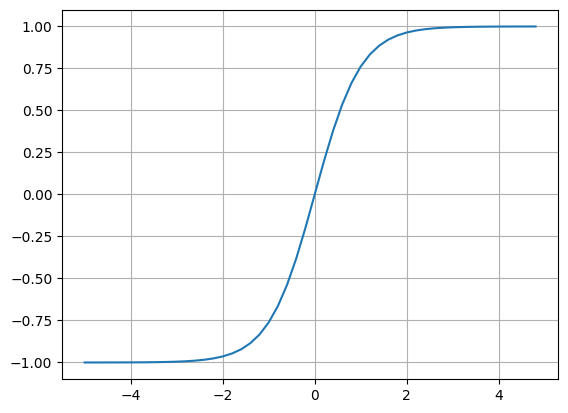

In [15]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid()

In [63]:
# inputs x1, x2

x1=Value(2.0, label='x1')
x2=Value(0.0, label='x2')

# weights w1, w2
w1=Value(-3.0, label='w1')
w2=Value(1.0, label='w2')

# bias
b=Value(6.8813735870195432, label='b')


# n = x1*w1 + x2*w2 + b
x1w1=x1*w1; x1w1.label='x1*w1'
x2w2=x2*w2; x2w2.label='x2*w2'
x1w1x2w2=x1w1+x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2+b; n.label='n'
o=n.tanh(); o.label='o'

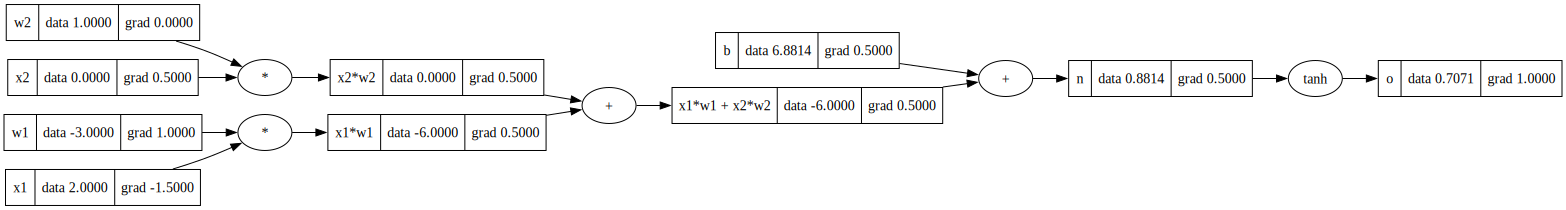

In [66]:
draw_dot(o)

In [65]:
o.backward()

In [59]:
o.grad=1.0

topo = []
visited = set() 
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)

for node in reversed(topo):
    node._backward()

In [56]:
topo = []
visited = set() 
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [46]:
o.grad=1.0
o._backward()

In [48]:
n._backward()

In [50]:
b._backward()

In [52]:
x1w1x2w2._backward()

In [54]:
x2w2._backward()
x1w1._backward()

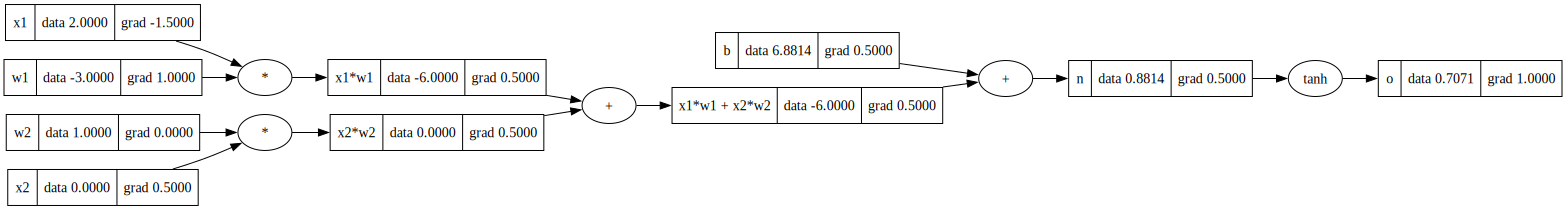

In [62]:
o.grad=1.0
n.grad=0.5
x1w1x2w2.grad=0.5
x1w1.grad=0.5
x2w2.grad=0.5
x2.grad=w2.data * x2w2.grad
w2.grad=x2.data * x2w2.grad
x1.grad=w1.data * x1w1.grad
w1.grad=x1.data * x1w1.grad
draw_dot(o)

In [ ]:
# O = tanh(n)   
# dO/dn = 1 - O^2